# Kaggle ML Competiton Entry

## Titanic Survivability Prediction

----

April 2022

# 0. Configure environment

## 0.1 Import libraries

In [1]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Feature selection
from sklearn.feature_selection import RFE

# Visualization
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

# Environment setup
%matplotlib inline
pd.set_option('display.max_columns', None)

## 0.2 Set data path

In [2]:
data_path = "/".join(os.getcwd().split("/")[:-1]) + "/data/raw/"

## 0.3 Load data

In [3]:
titanic = pd.read_csv(f"{data_path}train.csv")

# 1. Data Exploration

----

## 1.1 Data fields

`PassengerId` > Passenger ID

`Survived` > 1 if the passenger survived, 0 if they did not

`Pclass` > Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

`Name` > Name of passenger

`Sex` > Sex of passenger

`Age` > Age of passenger

`SibSp` > Number of siblings / spouses aboard the Titanic

`Parch` > Number of parents / children aboard the Titanic

`Ticket` > Ticket Number

`Fare` > Passenger fare

`Cabin` > Cabin number

`Embarked` > Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)


## 1.2 Variable exploration

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 2. Data preparation

----

## 2.1 Drop unused columns

In [6]:
titanic = titanic.drop(columns = ["Name", "Ticket"])

## 2.2 NaN value handling

In [7]:
# Cabin column
titanic['Cabin'] = titanic['Cabin'].fillna("NONE")

In [8]:
# Age column -- fill all NA values with the average age of all passengers
titanic['Age'] = titanic['Age'].fillna(titanic["Age"].mean())

# 3. Feature engineering

----

## 3.1 Utility functions

In [9]:
def removeNumbers(string):
    return (''.join([i for i in string if not i.isdigit()]))[0]

## 3.2 Dummy variables

Given the nature and makeup of the data, we will next create dummy variables for:

- Pclass
- Sex
- Cabin (specifically the level)
- Embarked

In [10]:
# PCLASS
pclass_df = pd.get_dummies(titanic['Pclass'], drop_first=False, dummy_na=True)
pclass_df.columns = ['FirstClass', 'SecondClass', 'ThirdClass', 'NoClass']
titanic = pd.concat([titanic, pclass_df], axis=1)

In [11]:
# SEX
sex_df = pd.get_dummies(titanic['Sex'], drop_first=False, dummy_na=True)
sex_df.columns = ['Female', 'Male', 'UnknownSex']
titanic = pd.concat([titanic, sex_df], axis=1)

In [12]:
# CABIN
titanic['Cabin'] = titanic['Cabin'].apply(removeNumbers)
cabin_df = pd.get_dummies(titanic['Cabin'], drop_first=False, dummy_na=True)
#cabin_df.columns = ['CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinG', 'CabinN', 'CabinT', 'NoCabin']
titanic = pd.concat([titanic, cabin_df], axis=1)

In [13]:
# Embarked
embarked_df = pd.get_dummies(titanic['Embarked'], drop_first=False, dummy_na=True)
embarked_df.columns = ['EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'EmbarkedNA']
titanic = pd.concat([titanic, embarked_df], axis=1)

In [14]:
# Get total number of contacts on boat
titanic['NumContacts'] = titanic['Parch'] + titanic['SibSp']

In [15]:
# Drop orignal columns
ids = titanic['PassengerId']
titanic = titanic.drop(columns = ['PassengerId', 'Pclass', 'Sex', 'Cabin', 'Embarked', 'Parch', 'SibSp'])

In [16]:
titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].mean())

# 4. Modeling

----

## 4.1 Functions and data handling

In [17]:
def rfe_selection(model, data):
    # Assign data-related variables
    features = ['Age', 'Fare', 'FirstClass', 'SecondClass', 'ThirdClass', 'NoClass', 'Female', 'Male', 'UnknownSex', 'CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinG', 'CabinN', 'CabinT', 'NoCabin', 'EmbarkedC', 'EmbarkedQ' , 'EmbarkedS', 'EmbarkedNA', 'NumContacts']
    df_vals = data.values

    # Identify the column names of the features
    inputs = df_vals[:,0:len(features)-1]
    response_variable = df_vals[:,len(features)-1]

    # Feature extraction
    #dt_classifier = DecisionTreeClassifier(max_depth = 5)
    rfe = RFE(model, step = 3)
    fit = rfe.fit(inputs, response_variable)

    # Create list with the target feature names
    selected_features = list(np.array(features[:-1])[np.array(fit.support_)])
    
    # Return a list containing the column names of the most relevant features
    return selected_features

In [18]:
# Split data before evaluation for consistency in results
x = titanic.drop(columns = ["Survived"]) #Use columns identified above
y = titanic[["Survived"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 4.2 Decision Tree

In [19]:
# Create empty lists
depth_list = []
model_error = []

dt_x_test = x_test
dt_y_test = y_test
dt_y_train = y_train
dt_x_train = x_train

# Loop through each depth
for d in range(2,11):
    # Append the depth to the list
    depth_list.append(d)
    
    # Create model input lists
    dt_selected_features = rfe_selection(model = DecisionTreeClassifier(max_depth = d), data = titanic) #Find most relevant model inputs
    
    # Create and fit model
    dt_classifier = DecisionTreeClassifier(max_depth = d)
    dt_classifier = dt_classifier.fit(dt_x_train[titanic.columns.intersection(dt_selected_features)], dt_y_train)
    
    # Test model and log error
    dt_y_pred = dt_classifier.predict(dt_x_test[titanic.columns.intersection(dt_selected_features)])
    model_error.append(accuracy_score(dt_y_pred, dt_y_test))

Text(0, 0.5, 'Accuracy')

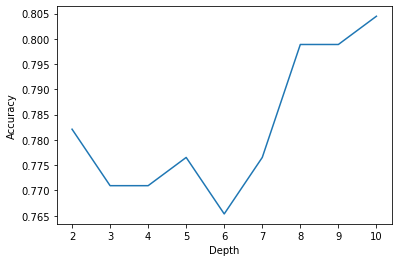

In [20]:
plt.plot(depth_list, model_error)
plt.xlabel("Depth")
plt.ylabel("Accuracy")

In [21]:
# Identify most-relevant model features
dt_selected_features = rfe_selection(model = DecisionTreeClassifier(max_depth = depth_list[model_error.index(max(model_error))]), data = titanic) #Find most relevant model inputs

# Split the data into x and y
dt_x = titanic[titanic.columns.intersection(dt_selected_features)] #Use columns identified above
dt_y = titanic[["Survived"]]

In [22]:
dt_selected_features

['Fare',
 'NoClass',
 'Female',
 'Male',
 'UnknownSex',
 'CabinC',
 'CabinD',
 'CabinE',
 'CabinF',
 'EmbarkedS',
 'EmbarkedNA']

In [23]:
# Create classifier with a depth equal to that of the lowest error
dt_classifier = DecisionTreeClassifier(max_depth = depth_list[model_error.index(max(model_error))])

# Fit the classifier with the training data
dt_classifier = dt_classifier.fit(dt_x_train, dt_y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [24]:
# Predict test data with classifier
dt_y_pred_test = dt_classifier.predict(dt_x_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [25]:
# Classification report
dt_class_report = classification_report(dt_y_test, dt_y_pred_test)
print(dt_class_report)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



## 4.3 Logistic Regression

In [26]:
lr_model = LogisticRegression().fit(x_train, np.ravel(y_train))
lr_y_pred_test = lr_model.predict(x_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that 

In [27]:
lr_class_report = classification_report(y_test, lr_y_pred_test)
print(lr_class_report)

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



# 5. Competition predictions
---

In [28]:
# VALIDATION SET
prediction_set = pd.read_csv(f"{data_path}test.csv")

In [29]:
prediction_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:
pred_ids = prediction_set["PassengerId"]

In [31]:
# Cabin column
prediction_set['Cabin'] = prediction_set['Cabin'].fillna("NONE")

In [32]:
# Age column -- fill all NA values with the average age of all passengers
prediction_set['Age'] = prediction_set['Age'].fillna(prediction_set["Age"].mean())

In [33]:
prediction_set = prediction_set.drop(columns=["PassengerId"])

In [34]:
# PCLASS
pclass_df = pd.get_dummies(prediction_set['Pclass'], drop_first=False, dummy_na=True)
pclass_df.columns = ['FirstClass', 'SecondClass', 'ThirdClass', 'NoClass']
prediction_set = pd.concat([prediction_set, pclass_df], axis=1)

In [35]:
# SEX
sex_df = pd.get_dummies(prediction_set['Sex'], drop_first=False, dummy_na=True)
sex_df.columns = ['Female', 'Male', 'UnknownSex']
prediction_set = pd.concat([prediction_set, sex_df], axis=1)

In [36]:
# CABIN
prediction_set['Cabin'] = prediction_set['Cabin'].apply(removeNumbers)
cabin_df = pd.get_dummies(prediction_set['Cabin'], drop_first=False, dummy_na=True)
#cabin_df.columns = ['CabinA', 'CabinB', 'CabinC', 'CabinD', 'CabinE', 'CabinF', 'CabinG', 'CabinN', 'CabinT', 'NoCabin']
prediction_set = pd.concat([prediction_set, cabin_df], axis=1)

In [37]:
# Embarked
embarked_df = pd.get_dummies(prediction_set['Embarked'], drop_first=False, dummy_na=True)
embarked_df.columns = ['EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'EmbarkedNA']
prediction_set = pd.concat([prediction_set, embarked_df], axis=1)

In [38]:
# Get total number of contacts on boat
prediction_set['NumContacts'] = prediction_set['Parch'] + prediction_set['SibSp']

In [39]:
# Drop orignal columns
prediction_set = prediction_set.drop(columns = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Parch', 'SibSp'])

In [40]:
prediction_set['Fare'] = prediction_set['Fare'].fillna(prediction_set['Fare'].mean())

In [41]:
prediction_set = prediction_set.drop(columns = ['Ticket', 'Name'])

In [54]:
prediction_set['T'] = 0

In [52]:
x_test.head(1)

,Age,Fare,FirstClass,SecondClass,ThirdClass,NoClass,Female,Male,UnknownSex,A,B,C,D,E,F,G,N,T,NaN,EmbarkedC,EmbarkedQ,EmbarkedS,EmbarkedNA,NumContacts
709,29.699118,15.2458,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2


In [46]:
titanic.head(1)

,Survived,Age,Fare,FirstClass,SecondClass,ThirdClass,NoClass,Female,Male,UnknownSex,A,B,C,D,E,F,G,N,T,NaN,EmbarkedC,EmbarkedQ,EmbarkedS,EmbarkedNA,NumContacts
0,0,22.0,7.25,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [55]:
competition_predictions = lr_model.predict(prediction_set)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [57]:
submission = pd.DataFrame()
submission['PassengerId'] = pred_ids
submission['Survived'] = competition_predictions

In [59]:
submission.to_csv("titanic-submission.csv", index=False)